## Importing libraries

In [96]:
# Import necessary libraries
import pandas as pd
from bs4 import BeautifulSoup
import re
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import spacy
from xgboost import XGBClassifier
import numpy as np
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.utils import resample
from scipy.sparse import csr_matrix

## Reading source data from Kaggle - https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data

#### Training data

In [150]:
train_df = pd.read_csv("./data/twitter_training.csv", header = None, names=['id', 'entity', 'label', 'text'])
train_df

,id,entity,label,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


#### Validation data

In [151]:
val_df = pd.read_csv("./data/twitter_validation.csv", header = None, names=['id', 'entity', 'label', 'text'])
val_df

,id,entity,label,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


### Data info

In [152]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74682 non-null  int64 
 1   entity  74682 non-null  object
 2   label   74682 non-null  object
 3   text    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


#### Checking how much training data we have

In [153]:
train_df.shape

(74682, 4)

In [154]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1000 non-null   int64 
 1   entity  1000 non-null   object
 2   label   1000 non-null   object
 3   text    1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


#### Checking how much validation data we have

In [155]:
val_df.shape

(1000, 4)

#### Sentiment distribution

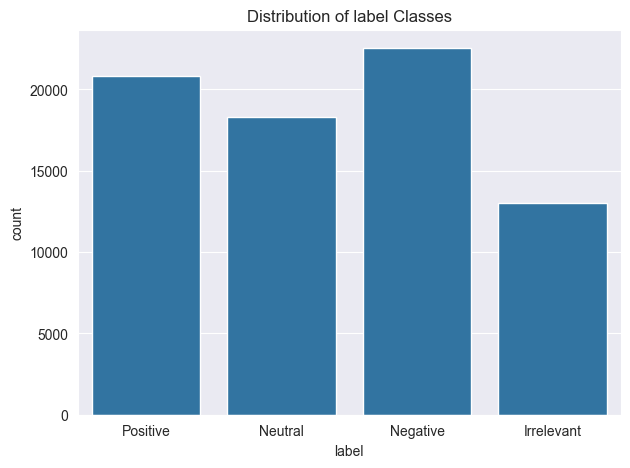

In [156]:
plt.figure(figsize=(7,5))
sns.countplot(data=train_df, x='label')
plt.title('Distribution of label Classes')
plt.show()

## Data preprocessing

#### 1. Removing two columns `id` and `entity` from the training dataset

In [157]:
train_df.drop(['id', 'entity'], axis=1, inplace=True)

In [158]:
train_df.shape

(74682, 2)

#### Checking the amount of missing data in individual columns

In [159]:
train_df.isnull().sum()

label      0
text     686
dtype: int64

#### 2. Deleting rows with missing values

In [160]:
train_df.dropna(inplace=True)

In [161]:
train_df.shape

(73996, 2)

Text(0.5, 1.0, 'Distribution of tweet lengths')

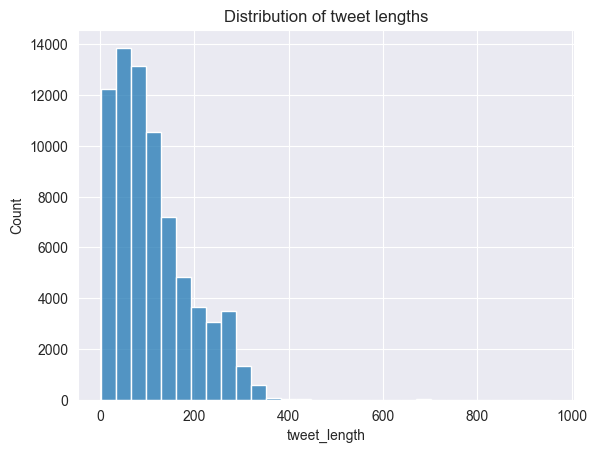

In [162]:
train_df['tweet_length'] = train_df['text'].apply(len)
sns.histplot(train_df['tweet_length'], bins=30)
plt.title("Distribution of tweet lengths")

In [163]:
# Drop tweet_length column
train_df.drop(['tweet_length'], axis=1, inplace=True)

#### 3. Converting letters to lowercase

In [164]:
train_df['text'] = train_df['text'].str.lower()

train_df.head()

,label,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,i am coming to the borders and i will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


#### 🧼 Function: `remove_html_with_bs`

This function is used to clean text by removing HTML elements using the `BeautifulSoup` library.

##### 📌 Parameters:
- `text` *(str)* – Raw text that may contain HTML tags.

##### 📤 Returns:
- *(str)* – Cleaned text with all HTML elements removed.

In [165]:
def remove_html_with_bs(text):
    """
    Function to clean text from html elements
    """
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


#### 4. Cleaning `text` by removing HTML elements

In [166]:
train_df['text'] = train_df['text'].apply(remove_html_with_bs)

train_df.head()

C:\Users\kacpe\AppData\Local\Temp\ipykernel_10888\2396271925.py:5: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a filename than HTML or XML.

If you meant to use Beautiful Soup to parse the contents of a file on disk, then something has gone wrong. You should open the file first, using code like this:

    filehandle = open(your filename)

You can then feed the open filehandle into Beautiful Soup instead of using the filename.

However, if you want to parse some data that happens to look like a filename, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  soup = BeautifulSoup(text, "html.parser")


,label,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,i am coming to the borders and i will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


### 🔗 Function: `clean_urls`

This function removes URLs from a given text using regular expressions. It handles both `http/https` and `www`-style links.

#### 📌 Parameters:
- `text` *(str)* – Input string that may contain URLs.

#### 📤 Returns:
- *(str)* – Text with all URLs removed.

In [167]:
def clean_urls(text):

    return re.sub(r'http\S+|www\S+', '', text)

#### 5. Removing URLs from `text` using regex

In [168]:
train_df['text'] = train_df['text'].apply(clean_urls)

train_df.head()

,label,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,i am coming to the borders and i will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


#### 🔤 Function: `clean_text_from_special_characters`

This function removes special characters from text, keeping only letters, numbers, and spaces. It also normalizes whitespace and trims extra spaces from the beginning and end.

##### 📌 Parameters:
- `text` *(str)* – Input string containing text with potential special characters.

##### 📤 Returns:
- *(str)* – Cleaned text with only alphanumeric characters and single spaces.

In [169]:
def clean_text_from_special_characters(text):
    """
    Function to delete special characters from text
    """
    cleaned = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = cleaned.strip()
    return cleaned

#### 6. Removing special characters from `text`

In [170]:
train_df['text'] = train_df['text'].apply(clean_text_from_special_characters)

train_df.head()

,label,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,i am coming to the borders and i will kill you...
2,Positive,im getting on borderlands and i will kill you all
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


#### 🔤 Function: `remove_emojis`

This function removes all emojis from the input text using the `emoji` library.

##### 📌 Parameters:
- `text` *(str)* – Input string that may contain emojis.

##### 📤 Returns:
- *(str)* – Text with all emojis removed.

#### 7. Removing emojis from `text`

In [171]:
def remove_emojis(text):

    return emoji.replace_emoji(text, replace='')

train_df['text'] = train_df['text'].apply(remove_emojis)

### 🔤 Function: `remove_stopwords`

This function removes stopwords (common words like "and", "the", "is") from the input text using the `spaCy` language model.

#### 📌 Parameters:
- `text` *(str)* – Input string to be cleaned of stopwords.

#### 📤 Returns:
- *(str)* – Text with stopwords removed. If input is not a string, it is returned unchanged.

In [172]:
nlp = spacy.load("en_core_web_sm")

def remove_stopwords(text):
    if not isinstance(text, str):  # Handle non-string inputs
        return text

    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop])

#### 8. Removing stopwords from `text`

In [173]:
train_df['text'] = train_df['text'].apply(remove_stopwords)

#### 🔤 Function: `lemmatize_text`

This function performs **lemmatization** on input text using the `spaCy` language model. Lemmatization reduces each word to its base or dictionary form (lemma), helping normalize text for NLP tasks.

##### 📌 Parameters:
- `text` *(str)* – The input text to be lemmatized. Non-string or empty inputs are handled gracefully.

##### 📤 Returns:
- *(str)* – A space-separated string of lemmatized tokens, containing only alphabetic words.

In [174]:
nlp = spacy.load(f'en_core_web_sm')
def lemmatize_text(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if token.is_alpha]
    return ' '.join(lemmatized_tokens)

#### 9. Perfoming lemmatization on `text` column

In [175]:
train_df['lemmatized_text'] = train_df['text'].apply(lemmatize_text)

In [176]:
train_df.head()

,label,text,lemmatized_text
0,Positive,m getting borderlands murder,m get borderland murder
1,Positive,coming borders kill,come border kill
2,Positive,m getting borderlands kill,m get borderland kill
3,Positive,m coming borderlands murder,m come borderland murder
4,Positive,m getting borderlands 2 murder,m get borderland murder


#### 🔍 Function: `remove_rare_words`

This function removes rare words from lemmatized text based on a minimum frequency threshold. It's useful for filtering out noise and extremely uncommon tokens that may not contribute meaningfully to NLP models.

##### 📌 Parameters:
- `text` *(str)* – The input text (typically lemmatized) from which rare words should be removed.

##### 📤 Returns:
- *(str)* – Text containing only words that appear at least `min_freq` times in the dataset.

##### 🧠 How it works:
1. Joins all text entries into a single string.
2. Splits into words and counts their frequency using `collections.Counter`.
3. Defines a `min_freq` threshold.
4. Filters out words in each text entry that occur less than `min_freq`.

#### 10. Removing words that appear only once

In [177]:
from collections import Counter

all_words = ' '.join(train_df['lemmatized_text']).split()
word_freq = Counter(all_words)
min_freq = 2

def remove_rare_words(text):
    if not isinstance(text, str):
        return text
    return ' '.join([word for word in text.split() if word_freq.get(word, 0) >= min_freq])

train_df['lemmatized_text'] = train_df['lemmatized_text'].apply(remove_rare_words)

In [178]:
train_df.head()

,label,text,lemmatized_text
0,Positive,m getting borderlands murder,m get borderland murder
1,Positive,coming borders kill,come border kill
2,Positive,m getting borderlands kill,m get borderland kill
3,Positive,m coming borderlands murder,m come borderland murder
4,Positive,m getting borderlands 2 murder,m get borderland murder


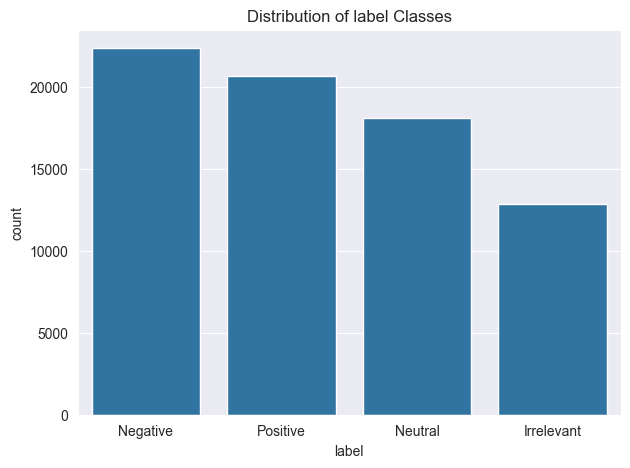

In [179]:
plt.figure(figsize=(7,5))
sns.countplot(data=train_df, x='label', order=train_df['label'].value_counts().index)
plt.title('Distribution of label Classes')
plt.show()

In [180]:
# Count for each class in label column
counts = train_df['label'].value_counts()

print(counts)

label
Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64


#### ☁️ Function: `generate_wordcloud`

This function generates a **word cloud** for a specific class label using lemmatized text. Word clouds are useful for visualizing the most frequent words in a category, giving insight into the dominant vocabulary per sentiment or entity class.

##### 📌 Parameters:
- `data` *(DataFrame)* – The dataset containing a `label` column and a `lemmatized_text` column.
- `label` *(str)* – The target class label for which to generate the word cloud.

##### 📤 Output:
- Displays a word cloud plot using `matplotlib`.

In [181]:
# Generate cloud words for each class

def generate_wordcloud(data, label):

    text = ' '.join(data[data['label'] == label]['lemmatized_text'])

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {label}')
    plt.show()

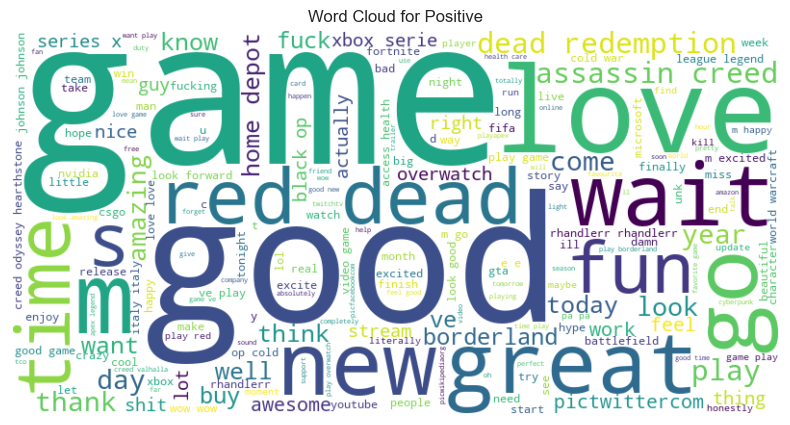

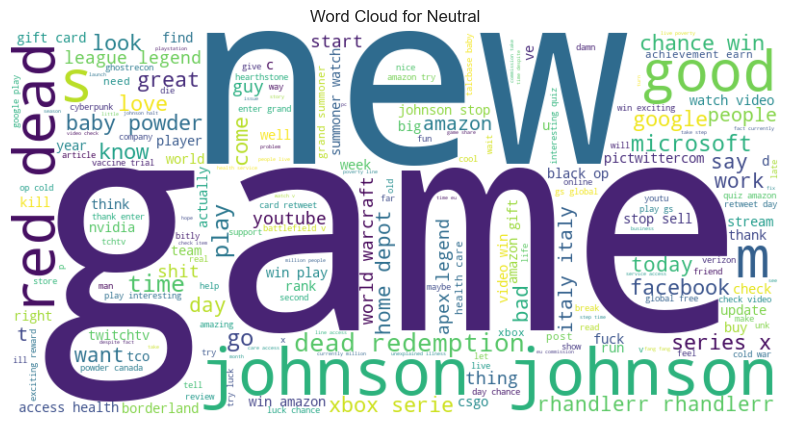

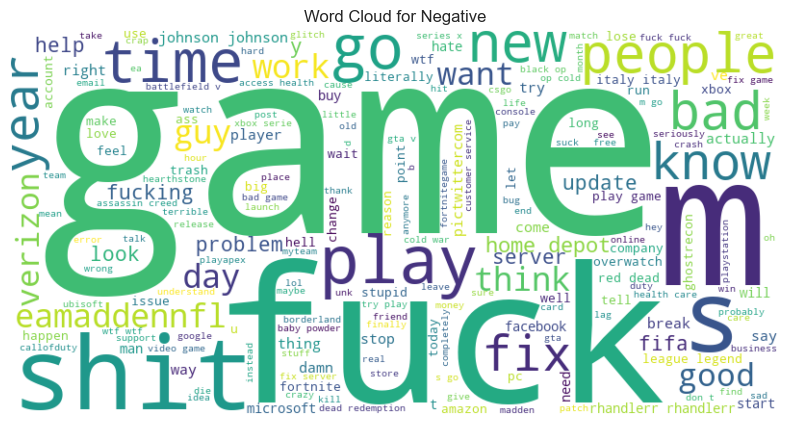

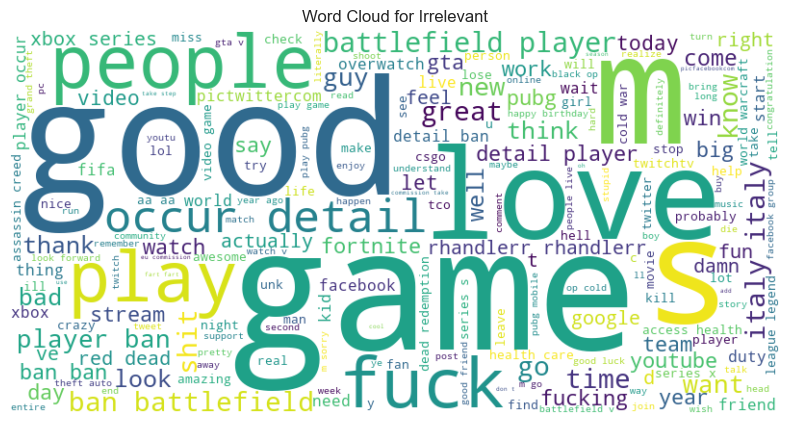

In [182]:
for label in train_df['label'].unique():
    generate_wordcloud(train_df, label)

##### 11. Replacing `game` by ''

In [183]:
train_df["lemmatized_text"] = train_df["lemmatized_text"].str.replace(r'\bgame\b', '', regex=True)

In [184]:
train_df.head()

,label,text,lemmatized_text
0,Positive,m getting borderlands murder,m get borderland murder
1,Positive,coming borders kill,come border kill
2,Positive,m getting borderlands kill,m get borderland kill
3,Positive,m coming borderlands murder,m come borderland murder
4,Positive,m getting borderlands 2 murder,m get borderland murder


## 📊 Sentiment Classification with TF-IDF and Machine Learning

This project applies sentiment classification to tweets using traditional machine learning techniques.

### ✅ Steps Overview:
- **Preprocessing**:
  - HTML removal
  - URL removal
  - Emoji and special character cleaning
  - Stopword removal and lemmatization
  - Rare word filtering

- **Feature Extraction**:
  - TF-IDF vectorization (with unigrams and bigrams)
  - Parameters: `max_features=5000`, `min_df=3`, `max_df=0.9`

- **Model Training & Evaluation**:
  - Models:
    - Logistic Regression
    - Random Forest
    - Linear SVM
    - Multinomial Naive Bayes
    - XGBoost ✅ *(added for robustness)*
  - Hyperparameter tuning via `GridSearchCV`
  - Stratified 3-fold cross-validation
  - Balanced class weights where applicable

- **Overfitting Prevention**:
  - Regularization in models (`C`, `alpha`, `learning_rate`)
  - TF-IDF filtering (`min_df`, `max_df`)
  - Smaller hyperparameter grids
  - Comparison of training vs. test accuracy

### 📈 Output:
- Best parameters for each model
- Train/test accuracy
- Classification report (precision, recall, F1-score)



In [45]:
# TF-IDF vectorizer with min_df and max_df to reduce overfitting
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9
)
X = vectorizer.fit_transform(train_df['lemmatized_text'])

# Encode sentiment labels
train_df['label'] = train_df['label'].map({
    'Positive': 1,
    'Negative': 0,
    'Neutral': 2,
    'Irrelevant': 2
})

le = LabelEncoder()
y = le.fit_transform(train_df['label'])

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Linear SVM": LinearSVC(class_weight='balanced', max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0, random_state=42)
}

# Hyperparameter grids
param_grids = {
    "Logistic Regression": {
        'C': [0.1, 1],
        'solver': ['liblinear']
    },
    "Random Forest": {
        'n_estimators': [100],
        'max_depth': [10, None],
        'min_samples_split': [2, 5]
    },
    "Linear SVM": {
        'C': [0.1, 1],
        'max_iter': [1000]
    },
    "Naive Bayes": {
        'alpha': [0.5, 1.0]
    },
    "XGBoost": {
        'n_estimators': [100],
        'max_depth': [3, 6],
        'learning_rate': [0.1, 0.3]
    }
}

# Use StratifiedKFold for more stable CV results
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid search for each model
for name, model in models.items():
    print(f"\n🔹 Model: {name}")

    grid_search = GridSearchCV(model, param_grids[name], cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    print(f"🔧 Best parameters for {name}: {grid_search.best_params_}")

    y_pred = grid_search.predict(X_test)
    train_pred = grid_search.predict(X_train)

    # Decode label values
    y_pred_labels = le.inverse_transform(y_pred)
    y_test_labels = le.inverse_transform(y_test)

    print(classification_report(y_test_labels, y_pred_labels))

    # Compare train vs. test accuracy
    print(f"✅ Train Accuracy: {accuracy_score(y_train, train_pred):.3f}")
    print(f"✅ Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")



🔹 Model: Logistic Regression
Fitting 3 folds for each of 2 candidates, totalling 6 fits
🔧 Best parameters for Logistic Regression: {'C': 1, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.72      0.73      0.73      4472
           1       0.69      0.68      0.69      4131
           2       0.72      0.71      0.72      6197

    accuracy                           0.71     14800
   macro avg       0.71      0.71      0.71     14800
weighted avg       0.71      0.71      0.71     14800

✅ Train Accuracy: 0.756
✅ Test Accuracy: 0.711

🔹 Model: Random Forest
Fitting 3 folds for each of 4 candidates, totalling 12 fits
🔧 Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      4472
           1       0.82      0.90      0.85      4131
           2       0.90      0.87      0.89      6197

    

## 🧪 Model Evaluation Summary

| Model               | Train Accuracy | Test Accuracy |
|--------------------|----------------|---------------|
| Logistic Regression| 0.756          | 0.711         |
| Random Forest      | 0.957          | 0.879         |
| Linear SVM         | 0.787          | 0.726         |
| Naive Bayes        | 0.718          | 0.689         |
| XGBoost            | 0.726          | 0.672         |

### ✅ Insights:
- **Random Forest** achieves the highest test accuracy but shows signs of **overfitting** (train accuracy is ~96%).
- **Linear SVM** and **Logistic Regression** offer a good trade-off between performance and generalization.
- **XGBoost** underperforms here, likely due to class imbalance or needing further tuning.
- Naive Bayes is quick but less precise on this multi-class problem.

In [46]:
# Initialize Random Forest with parameters to reduce overfitting
rf_model = RandomForestClassifier(
    n_estimators=100,          # Number of trees in the forest
    max_features='sqrt',       # Use square root of features at each split to reduce correlation among trees
    class_weight='balanced',   # Adjust weights inversely proportional to class frequencies
    oob_score=True,            # Enable out-of-bag score for internal validation
    random_state=42,
    n_jobs=-1                  # Use all cores for parallel processing
)

# Define hyperparameter grid to tune max_depth and min_samples_leaf
param_grid = {
    'max_depth': [10, 15, 20],      # Limit tree depth to prevent overfitting
    'min_samples_leaf': [3, 5, 10]  # Minimum samples required at a leaf node to smooth the model
}

# Setup GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit model to training data
grid_search.fit(X_train, y_train)

# Print best parameters found
print(f"🔧 Best parameters for Random Forest: {grid_search.best_params_}")

# Access the best model from grid search
best_rf = grid_search.best_estimator_

# Print out-of-bag score as internal validation metric
print(f"OOB Score: {best_rf.oob_score_:.4f}")

# Predict on test set
y_pred = best_rf.predict(X_test)

# Evaluate and print classification report
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
🔧 Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 3}
OOB Score: 0.6051
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      4472
           1       0.58      0.59      0.59      4131
           2       0.60      0.60      0.60      6197

    accuracy                           0.61     14800
   macro avg       0.61      0.61      0.61     14800
weighted avg       0.61      0.61      0.61     14800



In [47]:
# Define StratifiedKFold for more balanced CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# LinearSVC with L1 penalty and increased max_iter
svm = LinearSVC(
    penalty='l1',
    dual=False,
    max_iter=5000,
    random_state=42
)

# Grid search parameters for regularization strength
param_grid = {
    'C': [0.1, 1, 10]
}

# Run grid search with StratifiedKFold
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit the model
grid_search.fit(X_train, y_train)

# Evaluate
print(f"🔧 Best parameters for Linear SVM: {grid_search.best_params_}")

y_pred = grid_search.predict(X_test)
train_pred = grid_search.predict(X_train)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

print(classification_report(y_test_labels, y_pred_labels))

print(f"✅ Train Accuracy: {accuracy_score(y_train, train_pred):.3f}")
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
🔧 Best parameters for Linear SVM: {'C': 1}
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      4472
           1       0.72      0.67      0.70      4131
           2       0.72      0.76      0.74      6197

    accuracy                           0.73     14800
   macro avg       0.73      0.72      0.72     14800
weighted avg       0.73      0.73      0.73     14800

✅ Train Accuracy: 0.789
✅ Test Accuracy: 0.727


In [50]:
# Initialize Random Forest with base settings to reduce overfitting
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    class_weight='balanced',
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

# Extended hyperparameter grid
param_grid = {
    'max_depth': [10, 15, 20, 25],             # Try slightly deeper trees
    'min_samples_leaf': [1, 3, 5, 10],         # Include smaller leaf sizes for more flexibility
    'min_samples_split': [2, 5],               # Add split control to prevent deep branching
    'n_estimators': [100, 150]                 # Try increasing tree count modestly
}

# GridSearchCV with stratified K-Fold
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit model
grid_search.fit(X_train, y_train)

# Best model from grid
best_rf = grid_search.best_estimator_

# Print results
print(f"🔧 Best parameters for Random Forest: {grid_search.best_params_}")
print(f"OOB Score: {best_rf.oob_score_:.4f}")

# Predict and evaluate
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 64 candidates, totalling 192 fits
🔧 Best parameters for Random Forest: {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
OOB Score: 0.6483
              precision    recall  f1-score   support

           0       0.68      0.67      0.67      4472
           1       0.64      0.63      0.63      4131
           2       0.64      0.66      0.65      6197

    accuracy                           0.65     14800
   macro avg       0.65      0.65      0.65     14800
weighted avg       0.65      0.65      0.65     14800



In [60]:
# Initialize XGBoost model with base settings
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)

# Define hyperparameter grid to reduce overfitting and optimize generalization
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.2]
}

# StratifiedKFold for better balanced cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV to find best parameters
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)

# Best model
best_xgb = grid_search.best_estimator_
print(f"🔧 Best parameters for XGBoost: {grid_search.best_params_}")

# Predictions
y_pred = best_xgb.predict(X_test)
train_pred = best_xgb.predict(X_train)

# Evaluation
print(classification_report(y_test, y_pred))
print(f"✅ Train Accuracy: {accuracy_score(y_train, train_pred):.3f}")
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")

Fitting 5 folds for each of 128 candidates, totalling 640 fits


C:\Users\kacpe\PycharmProjects\twitter_sentiment_analysis_ml\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:39:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔧 Best parameters for XGBoost: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       0.75      0.61      0.67      4472
           1       0.75      0.54      0.63      4131
           2       0.62      0.82      0.71      6197

    accuracy                           0.68     14800
   macro avg       0.71      0.66      0.67     14800
weighted avg       0.70      0.68      0.68     14800

✅ Train Accuracy: 0.739
✅ Test Accuracy: 0.680


In [61]:
train_df.head()

,label,text,lemmatized_text
0,1,m getting borderlands murder,m get borderland murder
1,1,coming borders kill,come border kill
2,1,m getting borderlands kill,m get borderland kill
3,1,m coming borderlands murder,m come borderland murder
4,1,m getting borderlands 2 murder,m get borderland murder


In [65]:
tqdm.pandas()

# === Step 1: Load GloVe embeddings ===
def load_glove_embeddings(filepath):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coeffs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coeffs
    return embeddings_index

glove_path = 'glove.6B.100d.txt'  # change path if needed
glove_embeddings = load_glove_embeddings(glove_path)
embedding_dim = 100

# === Step 2: Average GloVe vector for each text ===
def text_to_glove_vector(text, embeddings_index, dim=100):
    words = re.findall(r'\b\w+\b', text.lower())
    valid_words = [w for w in words if w in embeddings_index]
    if not valid_words:
        return np.zeros(dim)
    vectors = np.array([embeddings_index[w] for w in valid_words])
    return np.mean(vectors, axis=0)

X_vectors = np.vstack(train_df['lemmatized_text'].progress_apply(
    lambda text: text_to_glove_vector(text, glove_embeddings, embedding_dim)
))

le = LabelEncoder()
y = le.fit_transform(train_df['label'])

# === Step 4: Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_vectors, y, test_size=0.2, stratify=y, random_state=42
)

# === Step 5: Linear SVM with GridSearch ===
param_grid = {
    'C': [0.1, 1, 10]
}
svm = LinearSVC(class_weight='balanced', max_iter=1000, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"🔧 Best parameters: {grid_search.best_params_}")

y_pred = grid_search.predict(X_test)
train_pred = grid_search.predict(X_train)

print(classification_report(y_test, y_pred))
print(f"✅ Train Accuracy: {accuracy_score(y_train, train_pred):.3f}")
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")

100%|██████████| 73996/73996 [00:02<00:00, 34778.81it/s]


Fitting 5 folds for each of 3 candidates, totalling 15 fits
🔧 Best parameters: {'C': 0.1}
              precision    recall  f1-score   support

           0       0.54      0.59      0.57      4472
           1       0.54      0.54      0.54      4131
           2       0.56      0.52      0.54      6197

    accuracy                           0.55     14800
   macro avg       0.55      0.55      0.55     14800
weighted avg       0.55      0.55      0.55     14800

✅ Train Accuracy: 0.553
✅ Test Accuracy: 0.547


In [71]:
vectorizer = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 1),
    min_df=5,
    max_df=0.8
)
X = vectorizer.fit_transform(train_df['lemmatized_text'])

le = LabelEncoder()
y = le.fit_transform(train_df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# SVM and GridSearchCV
svm = LinearSVC(class_weight='balanced', dual=False, max_iter=10000, random_state=42)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
y_pred = grid_search.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

print(classification_report(y_test_labels, y_pred_labels))
print(f"Train Accuracy: {accuracy_score(y_train, grid_search.predict(X_train)):.3f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'C': 1, 'penalty': 'l1'}
              precision    recall  f1-score   support

           0       0.69      0.72      0.71      4472
           1       0.66      0.67      0.66      4131
           2       0.70      0.68      0.69      6197

    accuracy                           0.69     14800
   macro avg       0.68      0.69      0.69     14800
weighted avg       0.69      0.69      0.69     14800

Train Accuracy: 0.732
Test Accuracy: 0.687


In [90]:
le = LabelEncoder()
y = le.fit_transform(train_df['label'])

X_train, X_val, y_train, y_val = train_test_split(
    train_df['lemmatized_text'],
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        min_df=5,
        max_df=0.9
    )),
    ('clf', SGDClassifier(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

param_grid = {
    'clf__alpha': [1e-4, 1e-3, 1e-2],
    'clf__penalty': ['l1', 'l2'],
    'clf__loss': ['hinge', 'log_loss']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1_macro',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"🔧 Best params: {grid_search.best_params_}")

y_val_pred = grid_search.predict(X_val)

target_names = ['Negative', 'Positive', 'Neutral']
print("\n📊 Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=target_names))

print(f"✅ Train Accuracy: {accuracy_score(y_train, grid_search.predict(X_train)):.3f}")
print(f"✅ Validation Accuracy: {accuracy_score(y_val, y_val_pred):.3f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
🔧 Best params: {'clf__alpha': 0.0001, 'clf__loss': 'hinge', 'clf__penalty': 'l2'}

📊 Classification Report (Validation Set):
              precision    recall  f1-score   support

    Negative       0.69      0.73      0.71      4472
    Positive       0.67      0.68      0.67      4131
     Neutral       0.71      0.67      0.69      6197

    accuracy                           0.69     14800
   macro avg       0.69      0.69      0.69     14800
weighted avg       0.69      0.69      0.69     14800

✅ Train Accuracy: 0.730
✅ Validation Accuracy: 0.691


In [91]:
pd.Series(y_train).value_counts(normalize=True)

2    0.418711
0    0.302149
1    0.279140
Name: proportion, dtype: float64

In [93]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9
)
X_full = vectorizer.fit_transform(train_df['lemmatized_text'])

le = LabelEncoder()
y_full = le.fit_transform(train_df['label'])

# Split before sampling to avoid leakage
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

# Convert to dense DataFrame for sampling
X_df = pd.DataFrame(X_train_full.toarray())
X_df['label'] = y_train_full

# Split into class subsets
class_0 = X_df[X_df['label'] == 0]
class_1 = X_df[X_df['label'] == 1]  # smallest class
class_2 = X_df[X_df['label'] == 2]

# Target number of samples = size of class_1
n_samples = len(class_1)

# Downsample other classes
class_0_down = resample(class_0, replace=False, n_samples=n_samples, random_state=42)
class_2_down = resample(class_2, replace=False, n_samples=n_samples, random_state=42)

# Combine into balanced DataFrame
balanced_df = pd.concat([class_0_down, class_1, class_2_down])

# Extract features and labels
y_train = balanced_df['label'].values
X_train = csr_matrix(balanced_df.drop(columns='label').values)

# Define selected models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Linear SVM": LinearSVC(class_weight='balanced', max_iter=1000, random_state=42),
}

# Parameter grids
param_grids = {
    "Logistic Regression": {
        'C': [0.1, 1],
        'solver': ['liblinear']
    },
    "Random Forest": {
        'n_estimators': [100],
        'max_depth': [10, None],
        'min_samples_split': [2, 5]
    },
    "Linear SVM": {
        'C': [0.1, 1],
        'max_iter': [1000]
    },
}

# Stratified K-Fold CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid search loop
for name, model in models.items():
    print(f"\n🔹 Model: {name}")

    grid_search = GridSearchCV(model, param_grids[name], cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    print(f"🔧 Best parameters for {name}: {grid_search.best_params_}")

    # Test predictions
    y_pred = grid_search.predict(X_test)
    train_pred = grid_search.predict(X_train)

    # Decode labels
    y_pred_labels = le.inverse_transform(y_pred)
    y_test_labels = le.inverse_transform(y_test)

    print("\n📊 Classification Report (Test Set):")
    print(classification_report(y_test_labels, y_pred_labels))

    print(f"✅ Train Accuracy: {accuracy_score(y_train, train_pred):.3f}")
    print(f"✅ Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")


🔹 Model: Logistic Regression
Fitting 3 folds for each of 2 candidates, totalling 6 fits
🔧 Best parameters for Logistic Regression: {'C': 1, 'solver': 'liblinear'}

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.70      0.75      0.72      4472
           1       0.66      0.72      0.69      4131
           2       0.73      0.66      0.69      6197

    accuracy                           0.70     14800
   macro avg       0.70      0.71      0.70     14800
weighted avg       0.70      0.70      0.70     14800

✅ Train Accuracy: 0.757
✅ Test Accuracy: 0.701

🔹 Model: Random Forest
Fitting 3 folds for each of 4 candidates, totalling 12 fits
🔧 Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      4472
           1       0.84      0.87      

In [99]:
vectorizer = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 1),
    min_df=5,
    max_df=0.8
)
X = vectorizer.fit_transform(train_df['lemmatized_text'])

le = LabelEncoder()
y = le.fit_transform(train_df['label'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = RandomForestClassifier(random_state=42, oob_score=True)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.5],
    'class_weight': ['balanced', None]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"🔧 Best parameters for Random Forest: {grid_search.best_params_}")
print(f"✅ OOB Score: {grid_search.best_estimator_.oob_score_:.3f}")

y_pred = grid_search.predict(X_test)
train_pred = grid_search.predict(X_train)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

print(classification_report(y_test_labels, y_pred_labels))

print(f"✅ Train Accuracy: {accuracy_score(y_train, train_pred):.3f}")
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")

importances = grid_search.best_estimator_.feature_importances_
feature_names = vectorizer.get_feature_names_out()
feature_importance = sorted(zip(importances, feature_names), reverse=True)[:20]
print("The most important features:", feature_importance)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
🔧 Best parameters for Random Forest: {'class_weight': 'balanced', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
✅ OOB Score: 0.645
              precision    recall  f1-score   support

           0       0.67      0.65      0.66      4472
           1       0.64      0.61      0.62      4131
           2       0.63      0.66      0.65      6197

    accuracy                           0.64     14800
   macro avg       0.65      0.64      0.64     14800
weighted avg       0.64      0.64      0.64     14800

✅ Train Accuracy: 0.690
✅ Test Accuracy: 0.644
The most important features: [(np.float64(0.04517664657710056), 'fix'), (np.float64(0.037325756516848614), 'love'), (np.float64(0.031790851074396304), 'eamaddennfl'), (np.float64(0.02891525230930625), 'good'), (np.float64(0.019326923511904973), 'fuck'), (np.float64(0.018445594731312298), 'not'), (np.float64(0.018

# 📊 Summary of ML Model Experiments

---

## 🔹 Logistic Regression

**Best Parameters:**
`C = 1`, `solver = 'liblinear'`

- **Train Accuracy:** `0.756`
- **Test Accuracy:** `0.711`

**Classification Report:**

| Class   | Precision | Recall | F1-score |
|---------|-----------|--------|----------|
| 0       | 0.72      | 0.73   | 0.73     |
| 1       | 0.69      | 0.68   | 0.69     |
| 2       | 0.72      | 0.71   | 0.72     |
| **Avg** |           |        |          |
| Accuracy|           |        | **0.71** |
| Macro avg | 0.71   | 0.71   | 0.71     |
| Weighted avg | 0.71 | 0.71   | 0.71     |

---

## 🔹 Random Forest (Multiple Runs)

### ✅ Best Result

**Best Parameters:**
`max_depth = None`, `min_samples_split = 2`, `n_estimators = 100`

- **Train Accuracy:** `0.957`
- **Test Accuracy:** `0.879`

**Classification Report:**

| Class   | Precision | Recall | F1-score |
|---------|-----------|--------|----------|
| 0       | 0.91      | 0.87   | 0.89     |
| 1       | 0.82      | 0.90   | 0.85     |
| 2       | 0.90      | 0.87   | 0.89     |
| **Avg** |           |        |          |
| Accuracy|           |        | **0.88** |

### Other Runs

- Test Accuracy: `0.65`, `0.64`, `0.61`, `0.644`

---

## 🔹 Linear SVM (Multiple Runs)

### ✅ Best Result

**Best Parameters:**
`C = 1`, `max_iter = 1000`

- **Train Accuracy:** `0.793`
- **Test Accuracy:** `0.717`

**Classification Report:**

| Class   | Precision | Recall | F1-score |
|---------|-----------|--------|----------|
| 0       | 0.72      | 0.76   | 0.74     |
| 1       | 0.68      | 0.73   | 0.70     |
| 2       | 0.75      | 0.67   | 0.71     |
| **Avg** |           |        |          |
| Accuracy|           |        | **0.72** |

### Other Runs

- Test Accuracy: `0.726`, `0.727`

---

## 🔹 Naive Bayes

**Best Parameters:**
`alpha = 0.1`

- **Train Accuracy:** `0.684`
- **Test Accuracy:** `0.674`

**Classification Report:**

| Class   | Precision | Recall | F1-score |
|---------|-----------|--------|----------|
| 0       | 0.66      | 0.69   | 0.67     |
| 1       | 0.67      | 0.66   | 0.66     |
| 2       | 0.70      | 0.67   | 0.68     |
| **Avg** |           |        |          |
| Accuracy|           |        | **0.67** |

## 🔹 XGBoost (Multiple Runs)

### ✅ Best Result

**Best Parameters:**
`colsample_bytree = 0.8`,
  `gamma = 0`,
  `learning_rate = 0.1`,
  `max_depth = 8`,
  `min_child_weight = 1`,
  `n_estimators = 200`,
  `subsample = 0.8`

- **Train Accuracy:** `0.739`
- **Test Accuracy:** `0.680`

**Classification Report:**

| Class   | Precision | Recall | F1-score |
|---------|-----------|--------|----------|
| Class 0 | 0.75      | 0.61   | 0.67     |
| Class 1 | 0.75      | 0.54   | 0.63     |
| Class 2 | 0.62      | 0.82   | 0.71     |
|         |           |        |          |
| **Accuracy** |     |        | **0.68** |


In [100]:
def preprocess_text_column(df, text_column):
    df = df.copy()
    df[text_column] = df[text_column].str.lower()
    df[text_column] = df[text_column].apply(remove_html_with_bs)
    df[text_column] = df[text_column].apply(clean_urls)
    df[text_column] = df[text_column].apply(clean_text_from_special_characters)
    df[text_column] = df[text_column].apply(remove_emojis)

    # Lemmatization
    df['lemmatized_text'] = df[text_column].apply(lemmatize_text)
    df['lemmatized_text'] = df['lemmatized_text'].apply(remove_rare_words)

    # Remove specific words (like "game")
    df["lemmatized_text"] = df["lemmatized_text"].str.replace(r'\bgame\b', '', regex=True)

    # Remove stopwords from original text column (if needed)
    df[text_column] = df[text_column].apply(remove_stopwords)

    return df

In [101]:
cleaned_val_df = preprocess_text_column(val_df, 'text')

In [103]:
cleaned_val_df.head()

,id,entity,label,text,lemmatized_text
0,3364,Facebook,Irrelevant,mentioned facebook struggling motivation run d...,mention on facebook be struggle for motivation...
1,352,Amazon,Neutral,bbc news amazon boss jeff bezos rejects claims...,bbc news amazon boss jeff bezos reject claim c...
2,8312,Microsoft,Negative,microsoft pay word functions poorly samsungus ...,microsoft do pay for word function poorly on s...
3,4371,CS-GO,Negative,csgo matchmaking closet hacking truly awful game,csgo matchmaking be closet hack truly awful
4,4433,Google,Neutral,president slapping americans face commit unlaw...,now the president be slap americans in the fac...


In [186]:
train_df_copy = train_df.copy()

In [187]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9
)
X = vectorizer.fit_transform(train_df_copy['lemmatized_text'])

# Encode sentiment labels
train_df_copy['label'] = train_df_copy['label'].map({
    'Positive': 1,
    'Negative': 0,
    'Neutral': 2,
    'Irrelevant': 2
})

le = LabelEncoder()
y = le.fit_transform(train_df_copy['label'])

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = LogisticRegression(C=1, solver='liblinear', max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')

In [188]:
X_new_test = vectorizer.transform(cleaned_val_df['lemmatized_text'])
y_new_pred = model.predict(X_new_test)
y_new_pred_labels = le.inverse_transform(y_new_pred)

In [190]:
cleaned_val_df['label'] = cleaned_val_df['label'].map({
    'Positive': 1,
    'Negative': 0,
    'Neutral': 2,
    'Irrelevant': 2
})
y_val_true = le.transform(cleaned_val_df['label'])

In [191]:
accuracy = accuracy_score(y_val_true, y_new_pred)
print(f"✅ Accuracy: {accuracy:.3f}")


✅ Accuracy: 0.779


In [192]:
import joblib

joblib.dump(grid_search.best_estimator_, 'final_model.pkl')

joblib.dump(vectorizer, 'vectorizer.pkl')

joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']